# Probablistic model building genetic algorithm

In [1]:
%cd /mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from src.kinetic_model import KineticModel, modelSpace_to_modelParams
from src.neural_network_builder import KineticNeuralNetworkBuilder
from notebooks.runAmber import get_uniform_ms, get_finkelstein_ms, get_reward_pipeline

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-_8uvxjka because the default path (/home/zzhang/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Using TensorFlow backend.


0.1.1-ga


In [3]:
import warnings
warnings.filterwarnings('ignore')
import time
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import pandas as pd
import numpy as np
from tqdm import tqdm
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import shutil
import os
import pickle
import gc
from sklearn.model_selection import train_test_split

## Load data

In [4]:
x = np.load('./data/compiled_X.npy')
y = np.load('./data/compiled_Y.npy')
with open('./data/y_col_annot.txt', 'r') as f:
    label_annot = [x.strip() for x in f]
    label_annot = {x:i for i,x in enumerate(label_annot)}
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=777)
label_annot

{'wtCas9_cleave_rate_log': 0,
 'Cas9_enh_cleave_rate_log': 1,
 'Cas9_hypa_cleave_rate_log': 2,
 'Cas9_HF1_cleave_rate_log': 3,
 'wtCas9_cleave_rate_log_specificity': 4,
 'Cas9_enh_cleave_rate_log_specificity': 5,
 'Cas9_hypa_cleave_rate_log_specificity': 6,
 'Cas9_HF1_cleave_rate_log_specificity': 7,
 'wtCas9_ndABA': 8,
 'Cas9_enh_ndABA': 9,
 'Cas9_hypa_ndABA': 10,
 'Cas9_HF1_ndABA': 11}

In [5]:
target_idx = label_annot['wtCas9_cleave_rate_log']

## Setup AMBER

In [6]:
import amber
print(amber.__version__)
from amber.architect import pmbga
from amber.architect import ModelSpace, Operation

0.1.1-ga


In [7]:
kinn_model_space = get_finkelstein_ms()
print(kinn_model_space)

StateSpace with 7 layers and 1 total combinations


In [8]:
controller = pmbga.ProbaModelBuildGeneticAlgo(
            model_space=kinn_model_space,
            buffer_type='population',
            buffer_size=50,  # buffer size controlls the max history going back
            batch_size=1,   # batch size does not matter in this case; all arcs will be retrieved
        )

## Components before they are implemented in AMBER

## A fancy For-Loop that does the work for `amber.architect.trainEnv`

In [9]:
# trainEnv parameters
samps_per_gen = 10   # how many arcs to sample in each generation; important
max_gen = 1500
epsilon = 0.05
patience = 200
n_warmup_gen = -1
wd = "outputs/notebook"

In [10]:
def compute_eps(model_space_probs, old_probs=None):
    delta = []
    samp_probs = {}
    for p in model_space_probs:
        #print(p)
        samp_probs[p] = model_space_probs[p].sample(size=10000)
        n = np.percentile(samp_probs[p], [10, 20, 30, 40, 50, 60, 70, 80, 90])
        if old_probs is None:
            delta.append( np.mean(np.abs(n)) )
        else:
            o = np.percentile(old_probs[p], [10, 20, 30, 40, 50, 60, 70, 80, 90])
            delta.append( np.mean(np.abs(o - n)) )
    return np.mean(delta), samp_probs 

# get prior probas
_, old_probs = compute_eps(controller.model_space_probs)

In [11]:
hist = []
pc_cnt = 0
best_indv = 0
stat_df = pd.DataFrame(columns=['Generation', 'GenAvg', 'Best', 'PostVar'])
for generation in range(max_gen):
    try:
        start = time.time()
        has_impr = False
        for _ in range(samps_per_gen):
            # get arc
            arc, _ = controller.get_action()
            # get reward
            try:
                test_pcc = get_reward_pipeline(
                    arc,
                    x_train=x_train,
                    y_train=y_train[:, target_idx], 
                    x_test=x_test, 
                    y_test=y_test[:, target_idx],
                    wd=wd)
            #except ValueError:
            #    test_pcc = 0
            except Exception as e:
                raise e
            rate_df = None
            # update best, or increase patience counter
            if test_pcc > best_indv:
                best_indv = test_pcc
                has_impr = True
                shutil.move(os.path.join(wd, "bestmodel.h5"), os.path.join(wd, "AmberSearchBestModel.h5"))
                shutil.move(os.path.join(wd, "model_params.pkl"), os.path.join(wd, "AmberSearchBestModel_config.pkl"))

            # store
            _ = controller.store(action=arc, reward=test_pcc)
            hist.append({'gen': generation, 'arc':arc, 'test_pcc': test_pcc, 'rate_df': rate_df})
        end = time.time()
        if generation < n_warmup_gen:
            print(f"Gen {generation} < {n_warmup_gen} warmup.. skipped - Time %.2f" % (end-start), flush=True)
            continue
        _ = controller.train(episode=generation, working_dir=".")
        delta, old_probs = compute_eps(controller.model_space_probs, old_probs)
        post_vars = [np.var(x.sample(size=100)) for _, x in controller.model_space_probs.items()]
        stat_df = stat_df.append({
            'Generation': generation,
            'GenAvg': controller.buffer.r_bias,
            'Best': best_indv,
            'PostVar': np.mean(post_vars)
        }, ignore_index=True)
        print("[%s] Gen %i - Mean fitness %.3f - Best %.4f - PostVar %.3f - Eps %.3f - Time %.2f" % (
            datetime.now().strftime("%H:%M:%S"),
            generation, 
            controller.buffer.r_bias, 
            best_indv, 
            np.mean(post_vars),
            delta,
            end-start), flush=True)
        #if delta < epsilon:
        #    print("stop due to convergence criteria")
        #    break
        pc_cnt = 0 if has_impr else pc_cnt+1
        if pc_cnt >= patience:
            print("early-stop due to max patience w/o improvement")
            break
    except KeyboardInterrupt:
        print("user interrupted")
        break

datapoints:  7 / total:  10
[23:52:09] Gen 0 - Mean fitness 0.669 - Best 0.8767 - PostVar 5.919 - Eps 0.689 - Time 224.26
datapoints:  13 / total:  20
[23:55:14] Gen 1 - Mean fitness 0.495 - Best 0.8862 - PostVar 5.542 - Eps 0.311 - Time 184.35
datapoints:  19 / total:  30
[23:58:35] Gen 2 - Mean fitness 0.589 - Best 0.8991 - PostVar 5.754 - Eps 0.227 - Time 200.46
datapoints:  25 / total:  40
[00:01:50] Gen 3 - Mean fitness 0.593 - Best 0.8991 - PostVar 5.408 - Eps 0.212 - Time 193.73
datapoints:  30 / total:  50
[00:05:02] Gen 4 - Mean fitness 0.524 - Best 0.8997 - PostVar 5.575 - Eps 0.059 - Time 191.66
datapoints:  36 / total:  60
[00:08:21] Gen 5 - Mean fitness 0.583 - Best 0.8997 - PostVar 5.473 - Eps 0.163 - Time 198.35
datapoints:  41 / total:  70
[00:11:32] Gen 6 - Mean fitness 0.575 - Best 0.8997 - PostVar 4.981 - Eps 0.111 - Time 190.14
datapoints:  48 / total:  80
[00:14:31] Gen 7 - Mean fitness 0.420 - Best 0.8997 - PostVar 5.352 - Eps 0.133 - Time 178.32
datapoints:  50 /

In [12]:
pd.DataFrame(hist).sort_values('test_pcc', ascending=False)

,gen,arc,test_pcc,rate_df
42,4,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.899723,None
20,2,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.899116,None
10,1,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.886169,None
51,5,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.886133,None
105,10,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.884619,None
...,...,...,...,...
14,1,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.047667,None
102,10,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.046567,None
93,9,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",0.039509,None
36,3,"[conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET'...",-0.001090,None


In [13]:
print("\n".join([str(x) 
                 for x in pd.DataFrame(hist).
                 sort_values('test_pcc', ascending=False).
                 head(1)['arc'].values[0]]))

conv1d:{'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'kernel_size': 3, 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3}
conv1d:{'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'kernel_size': 3, 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3}
conv1d:{'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'kernel_size': 5, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 3, 'RANGE_D': 10}
conv1d:{'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'kernel_size': 7, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 7, 'RANGE_D': 10}
conv1d:{'filters': 1, 'SOURCE': '2', 'TARGET': '3', 'kernel_size': 7, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 14, 'RANGE_D': 8}
conv1d:{'filters': 1, 'SOURCE': '3', 'TARGET': '2', 'kernel_size': 7, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 12, 'RANGE_D': 10}
conv1d:{'filters': 1, 'SOURCE': '3', 'TARGET': '0', 'kernel_size': 7, 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 11, 'RANGE_D': 3, 'CONTRIB': 1}


In [14]:
a = pd.DataFrame(hist)
a['arc'] = ['|'.join([f"{x.Layer_attributes['RANGE_ST']}-{x.Layer_attributes['RANGE_ST']+x.Layer_attributes['RANGE_D']}" for x in entry]) for entry in a['arc']]
a.drop(columns=['rate_df'], inplace=True)
a.to_csv(os.path.join(wd,"train_history.tsv"), sep="\t", index=False)

Text(0.5, 0, 'Generation')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


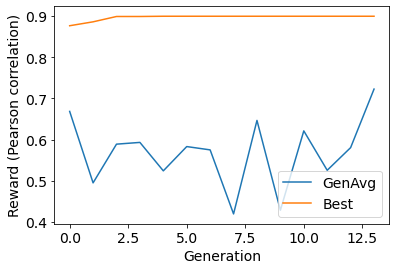

In [15]:
%matplotlib inline

ax = stat_df.plot.line(x='Generation', y=['GenAvg', 'Best'])
ax.set_ylabel("Reward (Pearson correlation)")
ax.set_xlabel("Generation")
#plt.savefig("reward_vs_time.png")

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


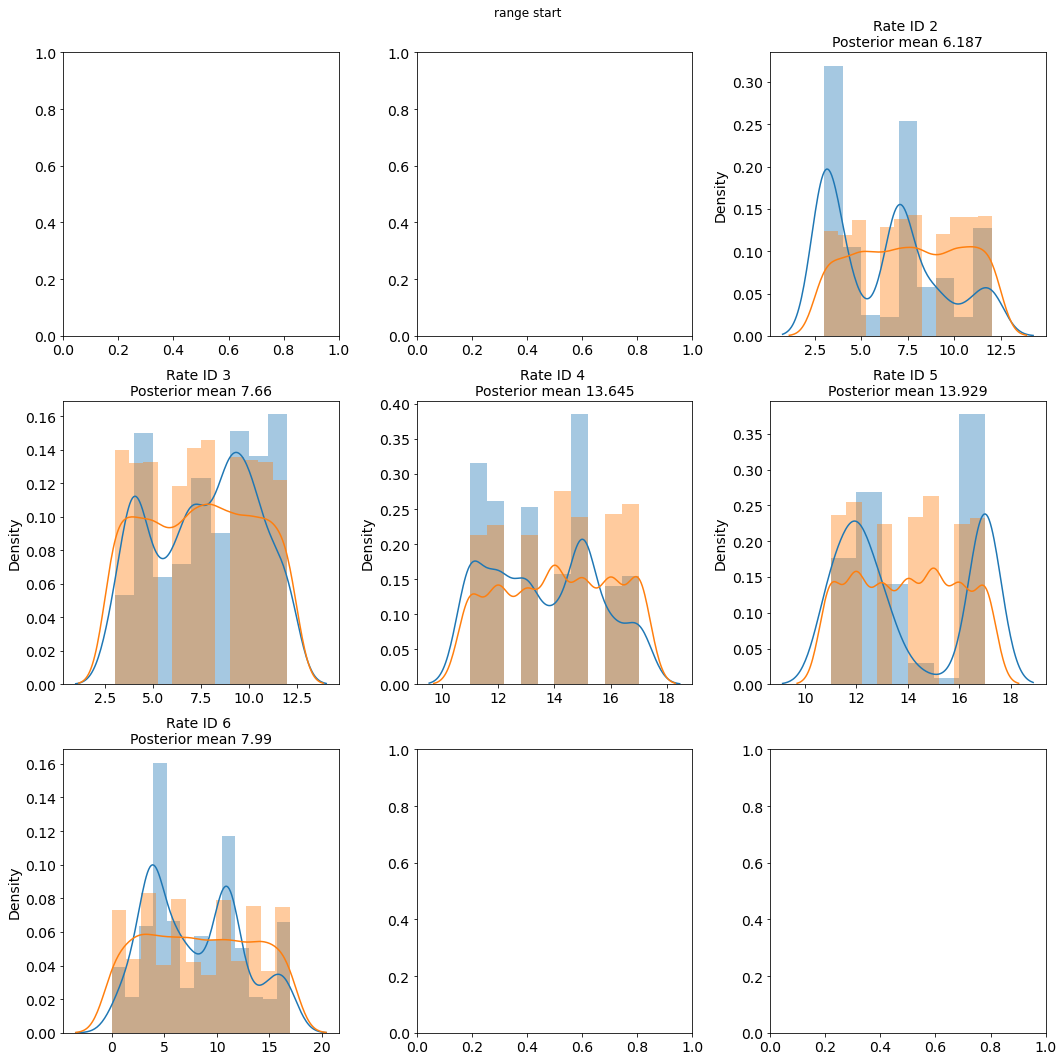

In [16]:
# START SITE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_ST':
        try:
            d = controller.model_space_probs[k].sample(size=1000)
        except:
            continue
        ax = axs[k[0]]
        sns.distplot(d, label="Post", ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        ax.set_title(
            ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))

        #_ = ax.set_xlim(0,50)

fig.suptitle('range start')
fig.tight_layout()
#fig.savefig("range_st.png")

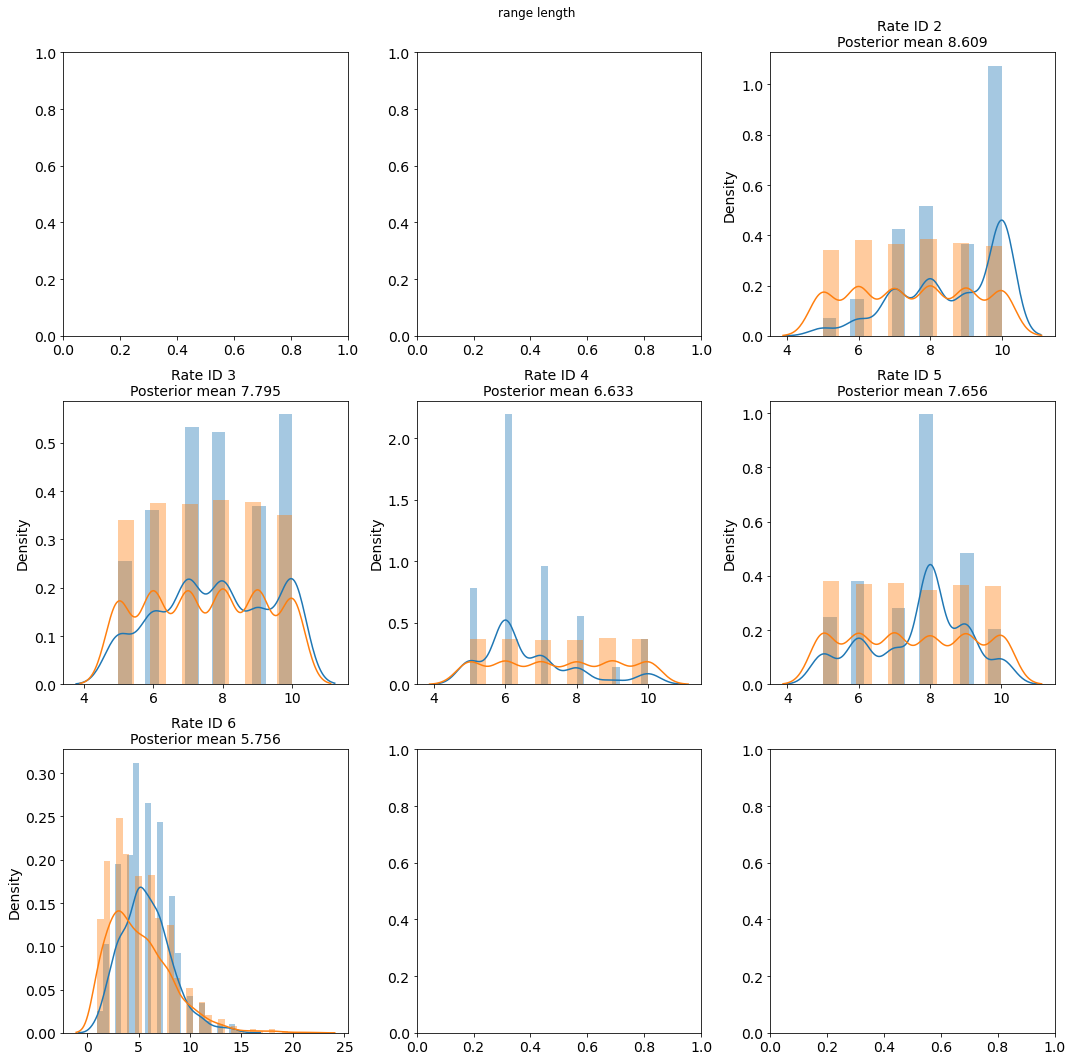

In [17]:
# CONV RANGE
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'RANGE_D':
        d = controller.model_space_probs[k].sample(size=1000)
        ax = axs[k[0]]
        sns.distplot(d, ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, label="Prior", ax=ax)
        ax.set_title(
                ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))
fig.suptitle('range length')
fig.tight_layout()
#fig.savefig("range_d.png")

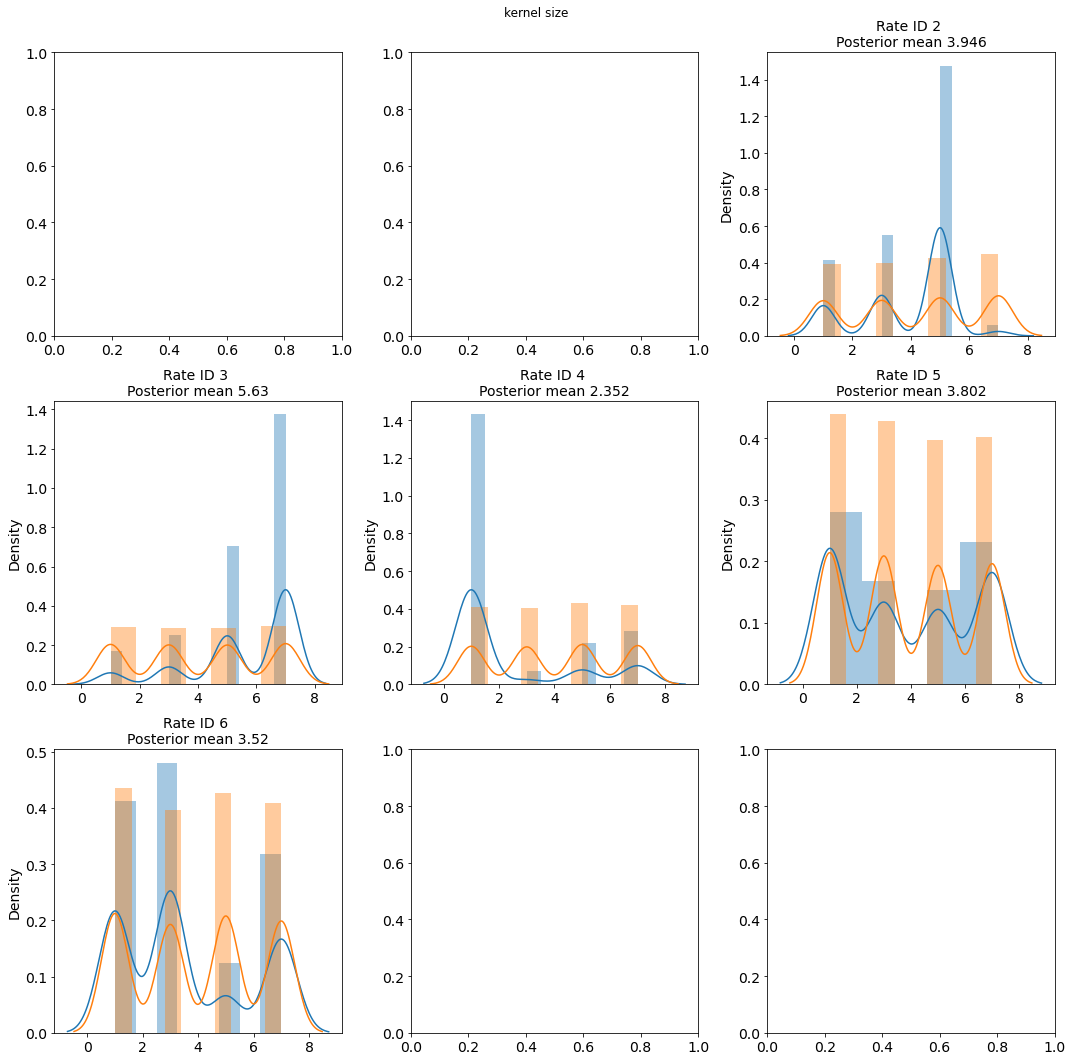

In [18]:
# KERNEL SIZE 
fig, axs_ = plt.subplots(3,3, figsize=(15,15))
axs = [axs_[i][j] for i in range(len(axs_)) for j in range(len(axs_[i]))]
for k in controller.model_space_probs:
    if k[-1] == 'kernel_size':
        d = controller.model_space_probs[k].sample(size=1000)
        ax = axs[k[0]]
        sns.distplot(d, ax=ax)
        sns.distplot(controller.model_space_probs[k].prior_dist, ax=ax)
        ax.set_title(
            ' '.join(['Rate ID', str(k[0]), '\nPosterior mean', str(np.mean(d))]))
        #_ = ax.set_xlim(0,20) 
fig.suptitle('kernel size')
fig.tight_layout()

In [19]:
# reload and re-train to full convergence
%run notebooks/reload

<Figure size 432x288 with 0 Axes>

In [20]:
pickle.load(open("outputs/notebook/AmberSearchBestModel_config.pkl", "rb"))

{'States': ['2', '0', '3', '1'],
 'Rates': [{'name': 'k_01',
   'state_list': ['0', '1'],
   'input_range': [0, 3],
   'kernel_size': 3,
   'filters': 1,
   'SOURCE': '0',
   'TARGET': '1',
   'padding': 'valid',
   'EDGE': 1,
   'RANGE_ST': 0,
   'RANGE_D': 3},
  {'name': 'k_10',
   'state_list': ['1', '0'],
   'input_range': [0, 3],
   'kernel_size': 3,
   'filters': 1,
   'SOURCE': '1',
   'TARGET': '0',
   'padding': 'valid',
   'EDGE': 1,
   'RANGE_ST': 0,
   'RANGE_D': 3},
  {'name': 'k_12',
   'state_list': ['1', '2'],
   'input_range': [3, 13],
   'kernel_size': 5,
   'filters': 1,
   'SOURCE': '1',
   'TARGET': '2',
   'padding': 'same',
   'EDGE': 1,
   'RANGE_ST': 3,
   'RANGE_D': 10},
  {'name': 'k_21',
   'state_list': ['2', '1'],
   'input_range': [7, 17],
   'kernel_size': 7,
   'filters': 1,
   'SOURCE': '2',
   'TARGET': '1',
   'padding': 'same',
   'EDGE': 1,
   'RANGE_ST': 7,
   'RANGE_D': 10},
  {'name': 'k_23',
   'state_list': ['2', '3'],
   'input_range': [14, 2

In [21]:
mb = reload_from_dir("outputs/notebook", replace_conv_by_fc=False, n_channels=8)
model = mb.model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0_3 (InputLayer)          [(None, 3, 8)]       0                                            
__________________________________________________________________________________________________
input_3_13 (InputLayer)         [(None, 10, 8)]      0                                            
__________________________________________________________________________________________________
input_7_17 (InputLayer)         [(None, 10, 8)]      0                                            
__________________________________________________________________________________________________
input_14_22 (InputLayer)        [(None, 8, 8)]       0                                            
______________________________________________________________________________________________

In [22]:
x_train_b = mb.blockify_seq_ohe(x_train)
x_test_b = mb.blockify_seq_ohe(x_test)
checkpointer = ModelCheckpoint(
    filepath=os.path.join(wd,"bestmodel.h5"), mode='min', verbose=0, save_best_only=True,
    save_weights_only=True)
earlystopper = EarlyStopping(
    monitor="val_loss",
    mode='min',
    patience=15,
    verbose=0)

model.fit(x_train_b, y_train[:,target_idx],
          batch_size=32,
          validation_split=0.2,
          callbacks=[checkpointer, earlystopper],
          epochs=225, verbose=2)
model.load_weights(os.path.join(wd,"bestmodel.h5"))
y_hat = model.predict(x_test_b).flatten()
test_pcc = ss.pearsonr(y_hat, y_test[:,target_idx])[0]

Train on 3186 samples, validate on 797 samples
Epoch 1/225
3186/3186 - 1s - loss: 15.8922 - val_loss: 15.5017
Epoch 2/225
3186/3186 - 0s - loss: 15.0819 - val_loss: 14.7755
Epoch 3/225
3186/3186 - 0s - loss: 14.3728 - val_loss: 14.0777
Epoch 4/225
3186/3186 - 0s - loss: 13.6926 - val_loss: 13.4068
Epoch 5/225
3186/3186 - 0s - loss: 13.0397 - val_loss: 12.7634
Epoch 6/225
3186/3186 - 0s - loss: 12.4122 - val_loss: 12.1472
Epoch 7/225
3186/3186 - 0s - loss: 11.8103 - val_loss: 11.5529
Epoch 8/225
3186/3186 - 0s - loss: 11.2326 - val_loss: 10.9839
Epoch 9/225
3186/3186 - 0s - loss: 10.6782 - val_loss: 10.4392
Epoch 10/225
3186/3186 - 0s - loss: 10.1472 - val_loss: 9.9149
Epoch 11/225
3186/3186 - 0s - loss: 9.6383 - val_loss: 9.4142
Epoch 12/225
3186/3186 - 0s - loss: 9.1513 - val_loss: 8.9347
Epoch 13/225
3186/3186 - 0s - loss: 8.6850 - val_loss: 8.4764
Epoch 14/225
3186/3186 - 0s - loss: 8.2394 - val_loss: 8.0371
Epoch 15/225
3186/3186 - 0s - loss: 7.8135 - val_loss: 7.6172
Epoch 16/225


Epoch 132/225
3186/3186 - 0s - loss: 0.2726 - val_loss: 0.3053
Epoch 133/225
3186/3186 - 0s - loss: 0.2721 - val_loss: 0.2916
Epoch 134/225
3186/3186 - 0s - loss: 0.2703 - val_loss: 0.2892
Epoch 135/225
3186/3186 - 0s - loss: 0.2709 - val_loss: 0.2995
Epoch 136/225
3186/3186 - 0s - loss: 0.2680 - val_loss: 0.2995
Epoch 137/225
3186/3186 - 0s - loss: 0.2720 - val_loss: 0.2919
Epoch 138/225
3186/3186 - 0s - loss: 0.2668 - val_loss: 0.2888
Epoch 139/225
3186/3186 - 0s - loss: 0.2667 - val_loss: 0.3079
Epoch 140/225
3186/3186 - 0s - loss: 0.2678 - val_loss: 0.2983
Epoch 141/225
3186/3186 - 0s - loss: 0.2638 - val_loss: 0.2823
Epoch 142/225
3186/3186 - 0s - loss: 0.2690 - val_loss: 0.2927
Epoch 143/225
3186/3186 - 0s - loss: 0.2649 - val_loss: 0.2940
Epoch 144/225
3186/3186 - 0s - loss: 0.2647 - val_loss: 0.2999
Epoch 145/225
3186/3186 - 0s - loss: 0.2629 - val_loss: 0.2796
Epoch 146/225
3186/3186 - 0s - loss: 0.2603 - val_loss: 0.2824
Epoch 147/225
3186/3186 - 0s - loss: 0.2683 - val_loss:

In [23]:
[str(x.__dict__) for x in mb.kinn.rates]

["{'name': 'k_01', 'state_list': ['0', '1'], 'input_range': [0, 3], 'kernel_size': 3, 'filters': 1, 'SOURCE': '0', 'TARGET': '1', 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3, 'template': None}",
 "{'name': 'k_10', 'state_list': ['1', '0'], 'input_range': [0, 3], 'kernel_size': 3, 'filters': 1, 'SOURCE': '1', 'TARGET': '0', 'padding': 'valid', 'EDGE': 1, 'RANGE_ST': 0, 'RANGE_D': 3, 'template': None}",
 "{'name': 'k_12', 'state_list': ['1', '2'], 'input_range': [3, 13], 'kernel_size': 5, 'filters': 1, 'SOURCE': '1', 'TARGET': '2', 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 3, 'RANGE_D': 10, 'template': None}",
 "{'name': 'k_21', 'state_list': ['2', '1'], 'input_range': [7, 17], 'kernel_size': 7, 'filters': 1, 'SOURCE': '2', 'TARGET': '1', 'padding': 'same', 'EDGE': 1, 'RANGE_ST': 7, 'RANGE_D': 10, 'template': None}",
 "{'name': 'k_23', 'state_list': ['2', '3'], 'input_range': [14, 22], 'kernel_size': 7, 'filters': 1, 'SOURCE': '2', 'TARGET': '3', 'padding': 'same', 'EDGE':

In [24]:
layer_dict = {l.name:l for l in model.layers}

In [25]:
layer_dict['output_nonneg'].get_weights()

[array([[1.902365]], dtype=float32), array([-5.150111], dtype=float32)]

In [26]:
np.around(layer_dict['conv_k0'].get_weights()[0],3)

array([[[ 0.   ],
        [ 0.   ],
        [ 0.24 ],
        [ 0.   ],
        [-0.924],
        [-2.057],
        [ 0.   ],
        [-2.033]],

       [[ 0.   ],
        [ 0.   ],
        [ 0.24 ],
        [ 0.   ],
        [-0.731],
        [-2.649],
        [ 0.   ],
        [-2.657]],

       [[ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [ 0.24 ],
        [ 0.045],
        [ 0.006],
        [ 0.016],
        [ 0.   ]]], dtype=float32)

In [27]:
np.around(layer_dict['conv_k1'].get_weights()[0],3)

array([[[ 0.   ],
        [ 0.   ],
        [ 0.479],
        [ 0.   ],
        [ 2.073],
        [ 2.649],
        [ 0.   ],
        [ 2.531]],

       [[ 0.   ],
        [ 0.   ],
        [ 0.479],
        [ 0.   ],
        [ 2.284],
        [ 2.256],
        [ 0.   ],
        [ 2.15 ]],

       [[ 0.   ],
        [ 0.   ],
        [ 0.   ],
        [ 0.479],
        [ 0.184],
        [-0.148],
        [-0.412],
        [ 0.   ]]], dtype=float32)

spearman SpearmanrResult(correlation=0.8906428200755243, pvalue=0.0)
pearson (0.9039158692051206, 0.0)


Text(0.5, 0.98, 'Testing prediction, pcc=0.904')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


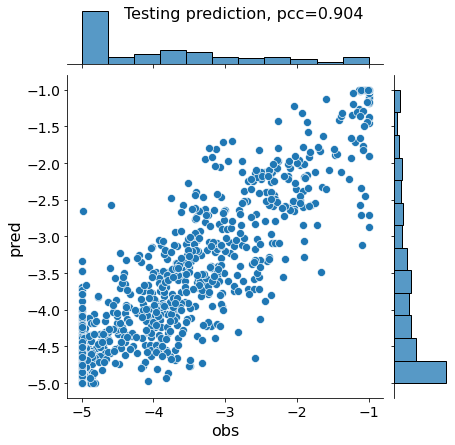

In [28]:
x_test_b = mb.blockify_seq_ohe(x_test)
y_hat = model.predict(x_test_b).flatten()
y_hat = np.clip(y_hat, -5, -1)
h = sns.jointplot(y_test[:,target_idx], y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test[:,target_idx]))
p = ss.pearsonr(y_hat, y_test[:,target_idx])
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)